<font size=20> Template Matching

In [50]:
from __future__ import print_function
import sys
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from concurrent.futures import ThreadPoolExecutor, as_completed

os.chdir("/usr/src/app")

In [133]:
def capture_frame(video_path, frame_num):
    cap = get_video(video_path)
    frame = get_frame(cap, frame_num)
    return cap, frame

def get_video(video_path):
    return cv2.VideoCapture(video_path)

def get_frame(cap, frame_num):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
    
    # Read the frame
    ret, frame = cap.read()

    return frame

def plot_frame(frame):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(14, 11))
    
    # Display the frame
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return fig, ax

def plot_frames_grid(frames, nrows, ncols, size=(14, 11)):
    # Create a 4x4 grid of subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=size)
    
    # Add content to each subplot (replace this with your data)
    idx = 0
    for i in range(nrows):
        for j in range(ncols):
            frame = frames[idx]
            ax = axes[i, j]
            ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            idx += 1
    
    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plot
    plt.show()


def plot_frame(frame, size=(14,11)):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=size)
    
    # Display the frame
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return fig, ax

def plot_net(ax, net_points, frame):
    # Draw the net (rectangle) on the frame in green
    net_points = np.array(net_points, dtype=int)
    cv2.polylines(frame, [net_points], isClosed=True, color=(0, 255, 0), thickness=2)
    ax.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    return ax

def plot_court(ax, court_points):
    # Extract court points and scatter them as black points
    court_points = np.array(court_points, dtype=int)
    ax.scatter(court_points[:, 0], court_points[:, 1], c='black', s=5)
    return ax

In [3]:
path = 'videos/tennistv/DhnpBjrgb34.mp4'
frame_num = 6007
net_points = [(525.21, 302.08), (1410.6, 302.08), (1410.6, 382.6), (525.21, 382.6)]
court_points = [(374.6, 757.1),
 (524.2, 756.6),
 (965.7, 757.7),
 (1408.1, 754.9),
 (1563.7, 757.4),
 (623.9, 537.9),
 (966.0, 539.4),
 (1313.9, 535.4),
 (743.0, 272.9),
 (968.3, 271.9),
 (1197.6, 272.8),
 (702.4, 207.8),
 (771.4, 205.4),
 (970.2, 207.3),
 (1171.1, 205.0),
 (1239.1, 205.3)
]

In [139]:
ex1 = 1000 # not match
ex2 = 1150  # perfect match
ex3 = 3500

# Load video frame
_, template = capture_frame(path, frame_num)
_, img = capture_frame(path, frame_num + ex1)

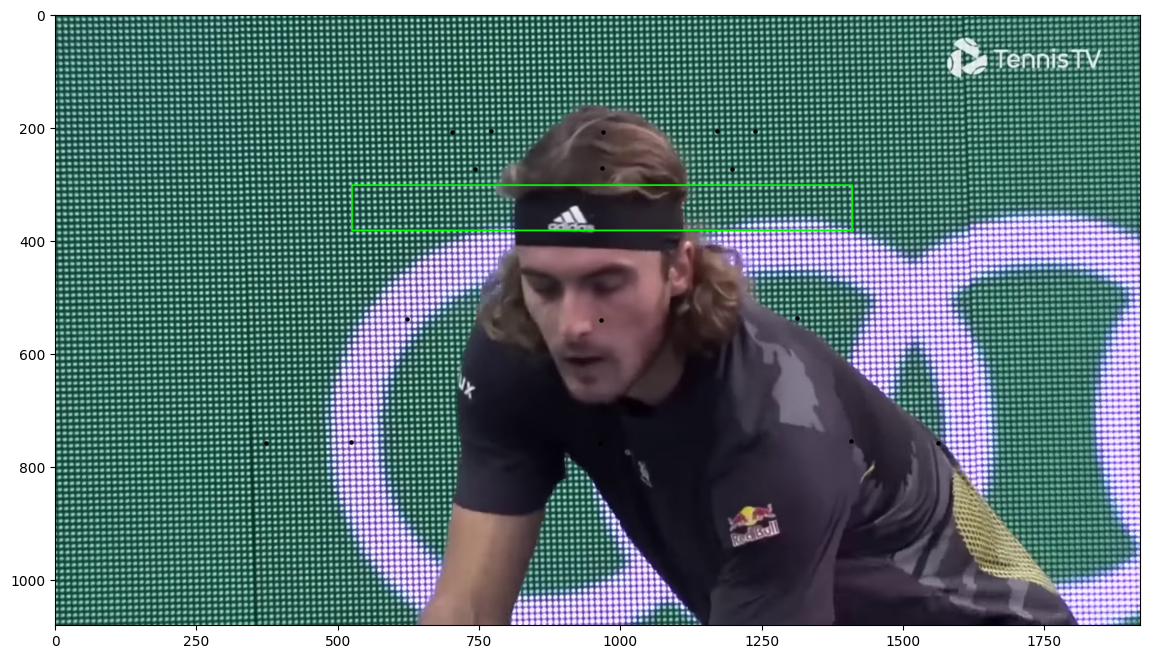

In [140]:
frame = img

# PLot frame
fig, ax = plot_frame(frame)

# Plot net
ax = plot_net(ax, net_points, frame)

# Plot court
ax = plot_court(ax, court_points)

# Show the plot
plt.show()

In [130]:
frame.shape

(1080, 1920, 3)

In [135]:
def get_patch(image, court_points, idx, w = 25):
    kp = court_points[idx]
    x,y = kp
    x = int(x); y = int(y)
    patch = image[y-w:y+w, x-w:x+w, :]
    return patch

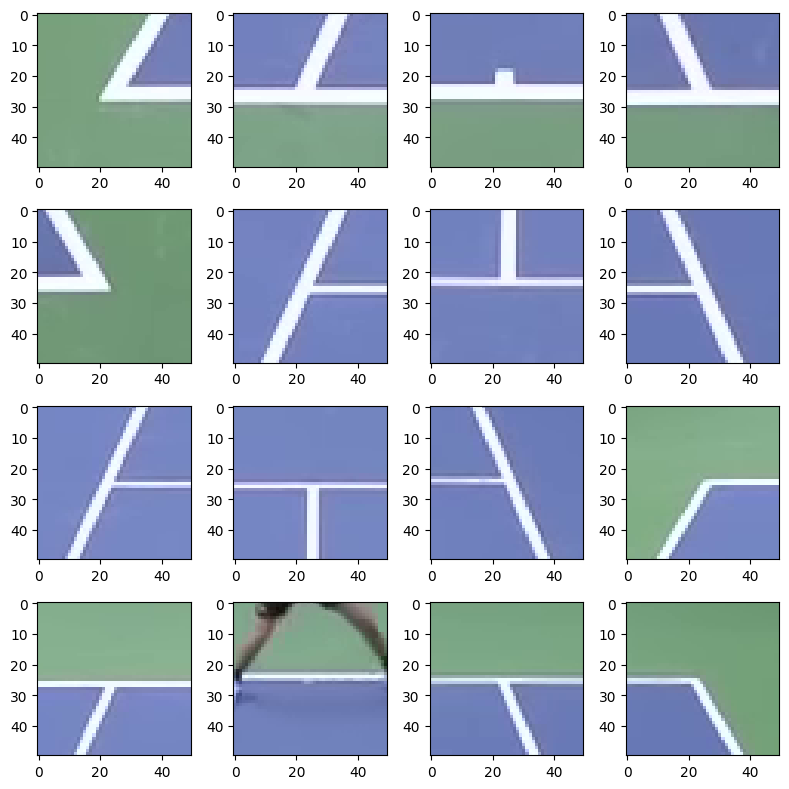

In [136]:
w = 25
patches = [get_patch(template, court_points, ii, w) for ii in range(len(court_points))]
plot_frames_grid(patches, 4, 4, size=(8, 8))

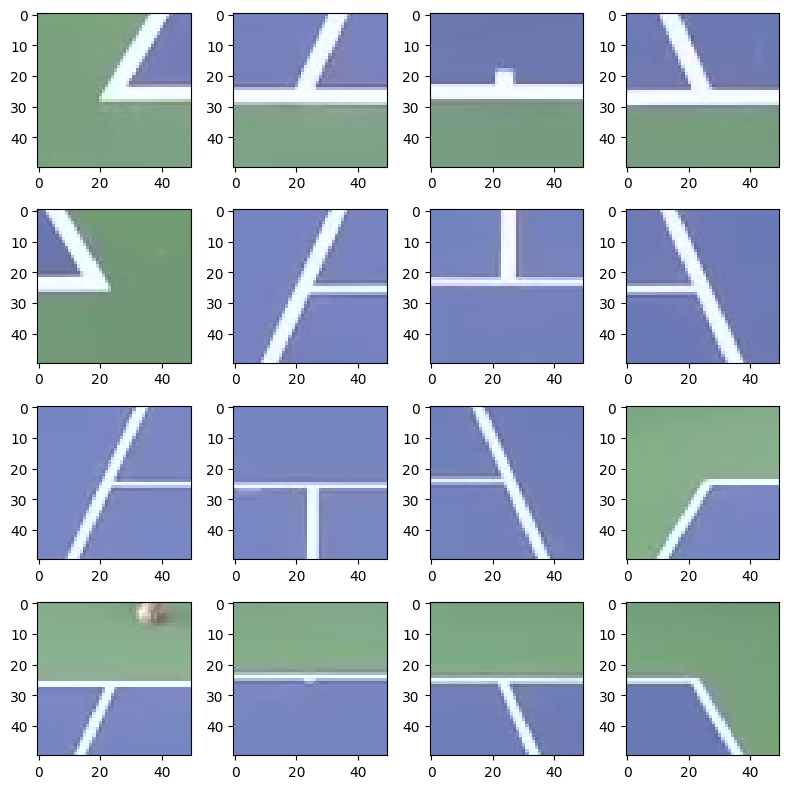

In [137]:
w = 25
patches = [get_patch(img, court_points, ii, w) for ii in range(len(court_points))]
plot_frames_grid(patches, 4, 4, size=(8, 8))

In [89]:
%%time
# Template matching
match_method = cv2.TM_SQDIFF
result = cv2.matchTemplate(img, patches[1], match_method)

CPU times: user 110 ms, sys: 36.7 ms, total: 147 ms
Wall time: 145 ms


In [93]:
match_patch(img, patches[1])

(524, 756)

In [141]:
def match_patch(img, patch):
    # Template matching
    match_method = cv2.TM_SQDIFF
    result = cv2.matchTemplate(img, patch, match_method)

    # Find the minimum value (best match) and its location
    # this is the top left corner of the box
    min_val, _, min_loc, _ = cv2.minMaxLoc(result)
    
    # Subtract the width to all tuple elements since we convert
    # top left into the center of the patch
    match_loc = tuple(map(lambda x: x + w, min_loc))
    
    return match_loc

def wrap_match_patch(img, patch, ii):
    return match_patch(img, patch), ii

In [142]:
def eval_match_patch(match_loc, true_loc):
    # Convert the float target center of the patch into integers
    true_loc = tuple(map(lambda x: int(x), true_loc))
    return mse(true_loc, match_loc)

In [82]:
%%time
match_loc = match_path(img, patches[0])
err_match = eval_match_patch(match_loc, court_points[0])

CPU times: user 101 ms, sys: 47 ms, total: 148 ms
Wall time: 147 ms


In [143]:
def match_all_patches(img, patches):
    d_match_loc = {}
    with ThreadPoolExecutor(len(patches)) as executor:
        pool_res = [executor.submit(wrap_match_patch, img, patch, idx_patch) for idx_patch, patch in enumerate(patches)]
        for future_res in as_completed(pool_res):
            res_match_patch, idx_patch = future_res.result()
            d_match_loc[idx_patch] = res_match_patch
    return d_match_loc

In [145]:
# Get patches
w = 25
patches = [get_patch(template, court_points, ii, w) for ii in range(len(court_points))]

In [146]:
%%time
# Match all patches to a location
res = match_all_patches(img, patches)

CPU times: user 1.94 s, sys: 1.5 s, total: 3.44 s
Wall time: 1.06 s


In [147]:
res

{0: (1702, 991),
 2: (1316, 677),
 1: (1709, 991),
 8: (1316, 676),
 7: (1317, 676),
 3: (1317, 675),
 5: (1316, 676),
 6: (1316, 677),
 4: (1318, 683),
 14: (1316, 677),
 9: (1316, 676),
 10: (1316, 674),
 13: (1317, 658),
 15: (1316, 675),
 12: (1316, 677),
 11: (1316, 677)}

In [148]:
%%time
errs = [eval_match_patch(res[ii], court_points[ii]) for ii in range(len(court_points))]

CPU times: user 3.9 ms, sys: 2.03 ms, total: 5.93 ms
Wall time: 5.15 ms


In [149]:
errs

[909170.0,
 729725.0,
 64800.5,
 7261.0,
 32750.5,
 249785.0,
 70772.0,
 9948.5,
 245772.5,
 142564.5,
 87882.5,
 298948.0,
 259904.5,
 161905.0,
 121904.5,
 113414.5]